In [52]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [54]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [55]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [56]:
tf.keras.backend.clear_session()

In [57]:
subject = 'Paraná - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [58]:
data = pd.read_csv('2003_mo_model_input_PR.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Paraná- custo m2 (R$),Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - IDH Educacao,Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,Paraná - Consumo de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,11767.370000,0.800130,1.312029e+07,8.284196,0.300568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819425,332.705560,0.728728,2.027147e+08,1.060612e+07,17.589536,1.851788e+08,0.776871,189.804,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,11852.421538,0.799796,1.313619e+07,8.277973,0.301710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819770,332.945945,0.729031,2.029477e+08,1.061597e+07,17.592548,1.852326e+08,0.776975,174.713,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,11934.318946,0.799462,1.315208e+07,8.271750,0.302645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820115,335.222130,0.729334,2.031806e+08,1.062582e+07,17.595559,1.852864e+08,0.777079,180.801,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,12015.342874,0.799128,1.316797e+07,8.265527,0.303413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820460,334.785737,0.729638,2.034136e+08,1.063567e+07,17.598570,1.853401e+08,0.777183,180.172,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,12093.451150,0.798794,1.318386e+07,8.259304,0.304034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820805,335.050185,0.729941,2.036466e+08,1.064551e+07,17.601581,1.853939e+08,0.777287,185.597,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39310.840386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,39274.836083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,39220.898111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,39146.237796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


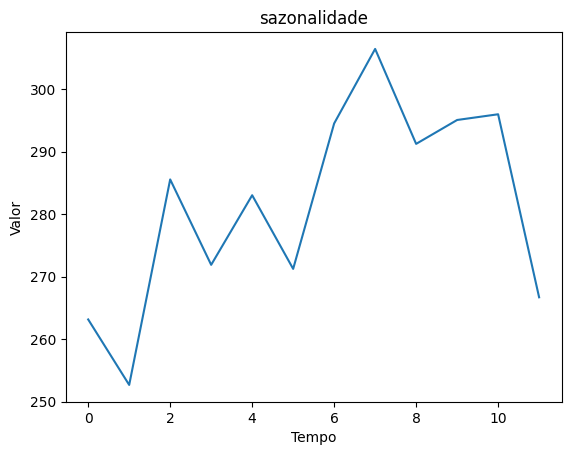

,sazonalidade
sazonalidade,
0,263.135121
1,252.658185
2,285.543932
3,271.875411
4,283.017533
5,271.230299
6,294.502922
7,306.431532
8,291.234296


In [59]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [60]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Paraná- custo m2 (R$),Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - IDH Educacao,Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Paraná - Consumo de Cimento (t)
0,2003-1,11767.370000,0.800130,1.312029e+07,8.284196,0.300568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819425,332.705560,0.728728,2.027147e+08,1.060612e+07,17.589536,1.851788e+08,0.776871,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,263.135121,189.804
1,2003-2,11852.421538,0.799796,1.313619e+07,8.277973,0.301710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819770,332.945945,0.729031,2.029477e+08,1.061597e+07,17.592548,1.852326e+08,0.776975,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,252.658185,174.713
2,2003-3,11934.318946,0.799462,1.315208e+07,8.271750,0.302645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820115,335.222130,0.729334,2.031806e+08,1.062582e+07,17.595559,1.852864e+08,0.777079,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,285.543932,180.801
3,2003-4,12015.342874,0.799128,1.316797e+07,8.265527,0.303413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820460,334.785737,0.729638,2.034136e+08,1.063567e+07,17.598570,1.853401e+08,0.777183,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,271.875411,180.172
4,2003-5,12093.451150,0.798794,1.318386e+07,8.259304,0.304034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820805,335.050185,0.729941,2.036466e+08,1.064551e+07,17.601581,1.853939e+08,0.777287,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,283.017533,185.597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39310.840386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.017533,NaN
245,2023-6,39274.836083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,271.230299,NaN
246,2023-7,39220.898111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,294.502922,NaN
247,2023-8,39146.237796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,306.431532,NaN


In [61]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      172.044
1      188.841
2      200.253
3      188.916
4      184.994
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Paraná - Consumo de Cimento (t), Length: 249, dtype: float64

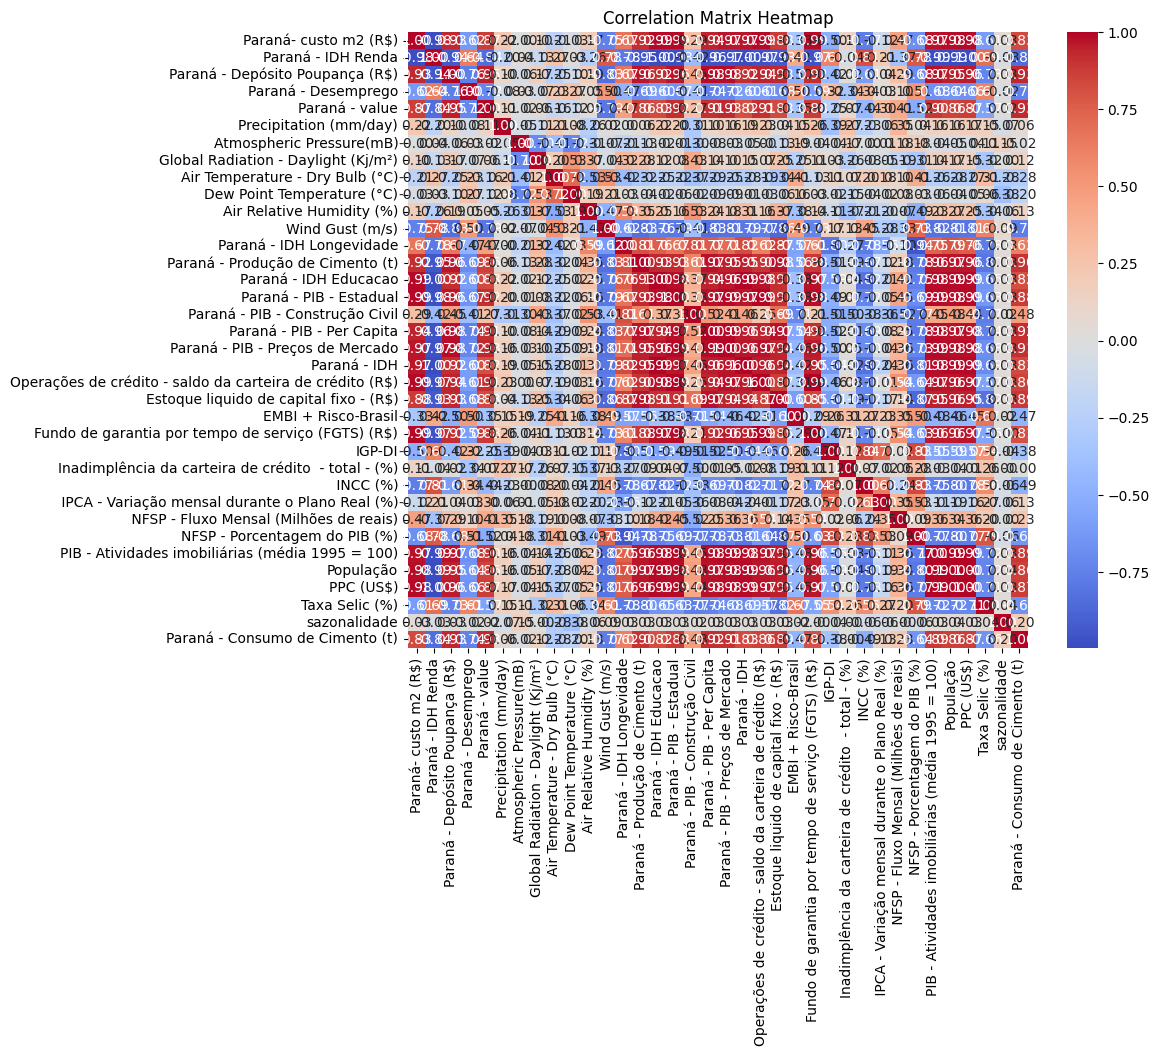

In [62]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [63]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [64]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Paraná- custo m2 (R$),1.431230e+06
1,Paraná - IDH Renda,1.567496e+08
2,Paraná - Depósito Poupança (R$),3.424312e+03
3,Paraná - Desemprego,1.397604e+05
4,Paraná - value,1.390545e+05
5,Precipitation (mm/day),1.086410e+01
6,Atmospheric Pressure(mB),1.436414e+04
7,Global Radiation - Daylight (Kj/m²),1.147682e+03
8,Air Temperature - Dry Bulb (°C),1.042661e+04
9,Dew Point Temperature (°C),5.758876e+03


In [65]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 4


,Paraná- custo m2 (R$),Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,11767.370000,0.800130,1.312029e+07,8.284196,0.300568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.819425,332.705560,2.027147e+08,1.060612e+07,17.589536,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,263.135121
1,11852.421538,0.799796,1.313619e+07,8.277973,0.301710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.819770,332.945945,2.029477e+08,1.061597e+07,17.592548,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,252.658185
2,11934.318946,0.799462,1.315208e+07,8.271750,0.302645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.820115,335.222130,2.031806e+08,1.062582e+07,17.595559,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,285.543932
3,12015.342874,0.799128,1.316797e+07,8.265527,0.303413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.820460,334.785737,2.034136e+08,1.063567e+07,17.598570,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,271.875411
4,12093.451150,0.798794,1.318386e+07,8.259304,0.304034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.820805,335.050185,2.036466e+08,1.064551e+07,17.601581,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,283.017533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,26189.046646,0.758489,2.683661e+07,7.487170,0.400855,1.964917,914.006975,1162.120506,17.279060,11.890180,71.455916,2.087106,0.833864,493.627481,2.425332e+08,1.097704e+07,18.016159,3.068648e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,1.987710e+08,416.859692,0.583985,306.431532
176,26291.298844,0.758506,2.696486e+07,7.477752,0.401377,2.002672,913.131668,1199.046199,18.103804,12.671529,71.331216,2.119287,0.833590,493.374474,2.424937e+08,1.097741e+07,18.015246,3.070265e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,1.988450e+08,417.748887,0.753312,291.234296
177,26394.587455,0.758524,2.709311e+07,7.468333,0.401647,2.165416,912.079818,1194.676048,18.545493,13.398295,71.793537,2.185808,0.833315,494.637705,2.424541e+08,1.097778e+07,18.014333,3.078615e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,1.989190e+08,418.601189,0.882343,295.058820
178,26499.003679,0.758542,2.722136e+07,7.458915,0.402140,2.169362,911.586292,1233.562731,19.084116,13.978850,72.052180,2.162289,0.833041,495.875938,2.424146e+08,1.097816e+07,18.013420,3.083099e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,1.989930e+08,419.430070,1.004174,295.973515


In [66]:
input_data = data.fillna(0.0).iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data = input_data.fillna(0.0)
input_data

,Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,1.928214,-1.375577,1.135376,-0.928691,-2.720908,-3.741616,-3.553506,-3.463290,-3.374470,-3.589078,-3.194276,-3.026166,-1.637316,-1.606120,-2.340956,-1.853019,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-1.181072
1,1.901370,-1.372732,1.121280,-0.910659,-2.720908,-3.741616,-3.553506,-3.463290,-3.374470,-3.589078,-3.194276,-2.946601,-1.633307,-1.589113,-2.294567,-1.833520,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-1.856870
2,1.874527,-1.369888,1.107184,-0.895896,-2.720908,-3.741616,-3.553506,-3.463290,-3.374470,-3.589078,-3.194276,-2.867037,-1.595339,-1.572106,-2.248179,-1.814020,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,0.264373
3,1.847684,-1.367043,1.093087,-0.883769,-2.720908,-3.741616,-3.553506,-3.463290,-3.374470,-3.589078,-3.194276,-2.787472,-1.602618,-1.555099,-2.201790,-1.794521,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.617293
4,1.820841,-1.364199,1.078991,-0.873955,-2.720908,-3.741616,-3.553506,-3.463290,-3.374470,-3.589078,-3.194276,-2.707907,-1.598207,-1.538092,-2.155401,-1.775021,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,0.101412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.418200,1.079404,-0.670068,0.655022,0.747630,0.272090,0.255423,0.034626,-0.102786,0.118809,0.128528,0.302578,1.046917,1.300715,-0.593728,0.909687,1.351069,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,1.611695
176,-1.416761,1.102358,-0.691403,0.663269,0.814275,0.268246,0.376450,0.201584,0.112209,0.112338,0.179763,0.239328,1.042697,1.297829,-0.591970,0.903774,1.352673,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,0.631421
177,-1.415322,1.125313,-0.712739,0.667524,1.101557,0.263627,0.362126,0.290998,0.312185,0.136328,0.285669,0.176077,1.063768,1.294942,-0.590212,0.897861,1.360954,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,0.878116
178,-1.413884,1.148267,-0.734074,0.675307,1.108523,0.261460,0.489580,0.400035,0.471929,0.149749,0.248224,0.112827,1.084422,1.292056,-0.588453,0.891949,1.365401,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.403443,1.454507,-0.000772,0.937117


In [67]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,1.928214,-1.375577,1.135376,-0.928691,-2.720908,-3.741616,-3.553506,-3.463290,-3.374470,-3.589078,-3.194276,-3.026166,-1.637316,-1.606120,-2.340956,-1.853019,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-1.181072
1,1.901370,-1.372732,1.121280,-0.910659,-2.720908,-3.741616,-3.553506,-3.463290,-3.374470,-3.589078,-3.194276,-2.946601,-1.633307,-1.589113,-2.294567,-1.833520,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-1.856870
2,1.874527,-1.369888,1.107184,-0.895896,-2.720908,-3.741616,-3.553506,-3.463290,-3.374470,-3.589078,-3.194276,-2.867037,-1.595339,-1.572106,-2.248179,-1.814020,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,0.264373
3,1.847684,-1.367043,1.093087,-0.883769,-2.720908,-3.741616,-3.553506,-3.463290,-3.374470,-3.589078,-3.194276,-2.787472,-1.602618,-1.555099,-2.201790,-1.794521,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.617293
4,1.820841,-1.364199,1.078991,-0.873955,-2.720908,-3.741616,-3.553506,-3.463290,-3.374470,-3.589078,-3.194276,-2.707907,-1.598207,-1.538092,-2.155401,-1.775021,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,0.101412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-1.440446,0.820355,-0.249301,0.595872,0.967447,0.270518,0.317311,-0.192889,-0.276814,0.233239,0.036523,0.995205,0.882861,1.309485,-0.529993,0.962319,1.407354,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.228701,1.261902,0.499090,1.611695
164,-1.438011,0.840029,-0.303585,0.581998,0.974761,0.267582,0.406776,-0.019605,-0.046429,0.229961,0.157976,0.945231,0.897453,1.311772,-0.545202,0.960070,1.402136,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.240408,1.276272,0.323875,0.631421
165,-1.435576,0.859702,-0.357869,0.572513,1.070670,0.264506,0.392378,0.201956,0.316419,0.272031,0.177851,0.895256,0.913574,1.314059,-0.560410,0.957822,1.398719,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.252114,1.290351,0.198030,0.878116
166,-1.433141,0.879376,-0.412153,0.564328,0.856242,0.262735,0.591858,0.433667,0.577645,0.239802,0.085270,0.845281,0.928670,1.316346,-0.575619,0.955573,1.393142,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.263821,1.304501,0.502803,0.937117


In [68]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      172.044
1      188.841
2      200.253
3      188.916
4      184.994
        ...   
163    344.937
164    302.082
165    294.467
166    336.029
167    278.117
Name: Paraná - Consumo de Cimento (t), Length: 168, dtype: float64

In [69]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [70]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 30)

In [71]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
132,-0.753838,1.387965,-0.726081,1.580396,0.279570,0.264331,0.702106,0.653481,0.717867,0.227039,-0.399631,0.129272,0.875957,1.017465,0.234366,0.986703,0.992500,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.848407,0.878252,-0.590376,-1.181072
133,-0.750626,1.353998,-0.659857,1.592156,-0.310243,0.265390,0.393971,0.513541,0.618515,0.290876,-0.483543,0.091028,0.888756,1.031809,0.204543,0.988439,1.013803,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.861179,0.887574,-0.476859,-1.856870
134,-0.747414,1.320031,-0.593634,1.599280,0.022764,0.267407,0.051867,0.307057,0.437608,0.352200,-0.559227,0.052785,0.883920,1.046154,0.174720,0.990176,1.036490,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.873950,0.896990,-0.089952,0.264373
135,-0.744202,1.286063,-0.527410,1.604093,0.045365,0.271410,-0.259348,0.034716,0.070843,0.337828,-0.612379,0.014542,0.878665,1.060499,0.144897,0.991913,1.059637,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.886722,0.906245,-0.814200,-0.617293
136,-0.740990,1.252096,-0.461187,1.607510,0.210369,0.273494,-0.384471,-0.176390,-0.378925,0.196141,-0.596533,-0.023702,0.873061,1.074843,0.115074,0.993649,1.080606,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.899493,0.915208,-0.917944,0.101412
137,-0.737778,1.218129,-0.394963,1.610217,0.527283,0.274180,-0.492691,-0.159305,-0.675480,-0.045121,-0.571219,-0.061945,0.866861,1.089188,0.085251,0.995386,1.101264,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.912265,0.924126,-0.708692,-0.658905
138,-0.734566,1.184162,-0.328740,1.603503,0.061478,0.273700,-0.144614,-0.059312,-0.779296,-0.212740,-0.543488,-0.100189,0.860358,1.103533,0.055428,0.997123,1.123860,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.925036,0.932114,-0.496126,0.842259
139,-0.731354,1.150195,-0.262516,1.591542,0.202926,0.270114,0.143900,0.119492,-0.611358,-0.254459,-0.443881,-0.138432,0.853300,1.117877,0.025605,0.998860,1.150086,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.937808,0.939863,-0.251065,1.611695
140,-0.728142,1.116227,-0.196292,1.574229,0.167082,0.266727,0.478626,0.365071,-0.215641,-0.187929,-0.334251,-0.176675,0.845929,1.132222,-0.004218,1.000596,1.179474,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.950580,0.947944,-0.593206,0.631421
141,-0.724930,1.082260,-0.130069,1.554681,-0.000339,0.265292,0.872595,0.516308,0.208470,-0.019279,-0.234799,-0.214919,0.838255,1.146567,-0.034041,1.002333,1.214576,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.963351,0.956229,-0.100794,0.878116


In [72]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 30)

In [73]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [74]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [75]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [76]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[205846631, 3170913713, 448808306, 3859082475, 3122644202, 1090379415, 1147010499, 3668584578, 3120112287, 3939665286]


Step: 0 ___________________________________________
val_loss: 1107.6859130859375
winner_seed: 205846631


Step: 1 ___________________________________________
val_loss: 933.2554321289062
winner_seed: 3170913713


Step: 2 ___________________________________________
val_loss: 873.2459106445312
winner_seed: 448808306


Step: 3 ___________________________________________
val_loss: 1130.6568603515625


Step: 4 ___________________________________________
val_loss: 971.3599853515625


Step: 5 ___________________________________________
val_loss: 980.419189453125


Step: 6 ___________________________________________
val_loss: 1181.3419189453125


Step: 7 ___________________________________________
val_loss: 1003.3816528320312


Step: 8 ___________________________________________
val_loss: 1107.8851318359375


Step: 9 ___________________________________________
val_loss: 1255.

In [77]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 448808306

Epoch 1/10000
4/4 [==============================] - 2s 129ms/step - loss: 77230.1719 - val_loss: 1337.8954
Epoch 2/10000
4/4 [==============================] - 0s 10ms/step - loss: 3096.8362 - val_loss: 1674.0808
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 2990.6753 - val_loss: 1486.8948
Epoch 4/10000
4/4 [==============================] - 0s 10ms/step - loss: 3385.3379 - val_loss: 1952.4525
Epoch 5/10000
4/4 [==============================] - 0s 10ms/step - loss: 3205.3003 - val_loss: 1214.8116
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 2817.1770 - val_loss: 1792.4266
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 2939.3140 - val_loss: 1123.8751
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 2817.4312 - val_loss: 2726.5557
Epoch 9/10000
4/4 [==============================] - 0s 9ms/step - loss: 2906.2627 - val_loss: 1201.6008
Epoch 10/10000
4/4 [============================

4/4 [==============================] - 0s 10ms/step - loss: 392.4665 - val_loss: 1287.9724
Epoch 156/10000
4/4 [==============================] - 0s 10ms/step - loss: 371.5013 - val_loss: 1176.8037
Epoch 157/10000
4/4 [==============================] - 0s 10ms/step - loss: 383.3989 - val_loss: 1188.2397
Epoch 158/10000
4/4 [==============================] - 0s 9ms/step - loss: 421.0554 - val_loss: 1153.8679
Epoch 159/10000
4/4 [==============================] - 0s 10ms/step - loss: 322.1243 - val_loss: 1135.1777
Epoch 160/10000
4/4 [==============================] - 0s 9ms/step - loss: 316.1957 - val_loss: 1183.6008
Epoch 161/10000
4/4 [==============================] - 0s 10ms/step - loss: 339.0018 - val_loss: 1378.2963
Epoch 162/10000
4/4 [==============================] - 0s 10ms/step - loss: 768.5999 - val_loss: 1175.1316
Epoch 163/10000
4/4 [==============================] - 0s 9ms/step - loss: 358.1899 - val_loss: 1170.0702
Epoch 164/10000
4/4 [==============================] - 0

4/4 [==============================] - 0s 9ms/step - loss: 124.5992 - val_loss: 945.6795
Epoch 310/10000
4/4 [==============================] - 0s 9ms/step - loss: 116.3372 - val_loss: 918.0356
Epoch 311/10000
4/4 [==============================] - 0s 10ms/step - loss: 99.0298 - val_loss: 910.9858
Epoch 312/10000
4/4 [==============================] - 0s 10ms/step - loss: 107.6799 - val_loss: 893.3989
Epoch 313/10000
4/4 [==============================] - 0s 9ms/step - loss: 114.6380 - val_loss: 899.1425
Epoch 314/10000
4/4 [==============================] - 0s 10ms/step - loss: 105.4671 - val_loss: 886.5760
Epoch 315/10000
4/4 [==============================] - 0s 10ms/step - loss: 121.6594 - val_loss: 952.5953
Epoch 316/10000
4/4 [==============================] - 0s 9ms/step - loss: 122.3938 - val_loss: 1074.6122
Epoch 317/10000
4/4 [==============================] - 0s 9ms/step - loss: 118.0240 - val_loss: 887.4468
Epoch 318/10000
4/4 [==============================] - 0s 8ms/step 

4/4 [==============================] - 0s 10ms/step - loss: 70.4765 - val_loss: 965.2473
Epoch 466/10000
4/4 [==============================] - 0s 9ms/step - loss: 65.7927 - val_loss: 888.8792
Epoch 467/10000
4/4 [==============================] - 0s 9ms/step - loss: 59.6737 - val_loss: 889.6927
Epoch 468/10000
4/4 [==============================] - 0s 9ms/step - loss: 58.2339 - val_loss: 862.8044
Epoch 469/10000
4/4 [==============================] - 0s 9ms/step - loss: 60.5387 - val_loss: 912.7567
Epoch 470/10000
4/4 [==============================] - 0s 9ms/step - loss: 54.7926 - val_loss: 864.6104
Epoch 471/10000
4/4 [==============================] - 0s 9ms/step - loss: 59.4006 - val_loss: 878.7078
Epoch 472/10000
4/4 [==============================] - 0s 9ms/step - loss: 59.5857 - val_loss: 982.4869
Epoch 473/10000
4/4 [==============================] - 0s 9ms/step - loss: 62.2252 - val_loss: 869.3738
Epoch 474/10000
4/4 [==============================] - 0s 9ms/step - loss: 63.3

4/4 [==============================] - 0s 8ms/step - loss: 46.7077 - val_loss: 953.2657
Epoch 622/10000
4/4 [==============================] - 0s 8ms/step - loss: 49.4358 - val_loss: 950.1919
Epoch 623/10000
4/4 [==============================] - 0s 8ms/step - loss: 49.3554 - val_loss: 916.1985
Epoch 624/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.7397 - val_loss: 925.5372
Epoch 625/10000
4/4 [==============================] - 0s 8ms/step - loss: 46.6005 - val_loss: 951.3306
Epoch 626/10000
4/4 [==============================] - 0s 7ms/step - loss: 44.2478 - val_loss: 959.0559
Epoch 627/10000
4/4 [==============================] - 0s 8ms/step - loss: 47.6656 - val_loss: 944.2153
Epoch 628/10000
4/4 [==============================] - 0s 8ms/step - loss: 55.1958 - val_loss: 905.6361
Epoch 629/10000
4/4 [==============================] - 0s 8ms/step - loss: 44.0367 - val_loss: 908.3983
Epoch 630/10000
4/4 [==============================] - 0s 8ms/step - loss: 47.21

Epoch 700/10000
4/4 [==============================] - 0s 9ms/step - loss: 46.4921 - val_loss: 955.6678
Epoch 701/10000
4/4 [==============================] - 0s 9ms/step - loss: 43.4265 - val_loss: 943.7390
Epoch 702/10000
4/4 [==============================] - 0s 10ms/step - loss: 45.4023 - val_loss: 926.5704
Epoch 703/10000
4/4 [==============================] - 0s 9ms/step - loss: 42.3316 - val_loss: 923.7032
Epoch 704/10000
4/4 [==============================] - 0s 10ms/step - loss: 42.1769 - val_loss: 920.8632
Epoch 705/10000
4/4 [==============================] - 0s 9ms/step - loss: 46.3555 - val_loss: 938.7827
Epoch 706/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.3648 - val_loss: 944.2123
Epoch 707/10000
4/4 [==============================] - 0s 11ms/step - loss: 45.6065 - val_loss: 950.4142
Epoch 708/10000
4/4 [==============================] - 0s 10ms/step - loss: 44.4688 - val_loss: 935.6881
Epoch 709/10000
4/4 [==============================] - 0s 11

4/4 [==============================] - 0s 9ms/step - loss: 37.7008 - val_loss: 994.5711
Epoch 857/10000
4/4 [==============================] - 0s 9ms/step - loss: 38.8445 - val_loss: 977.5370
Epoch 858/10000
4/4 [==============================] - 0s 10ms/step - loss: 36.9413 - val_loss: 948.5049
Epoch 859/10000
4/4 [==============================] - 0s 10ms/step - loss: 44.9355 - val_loss: 949.6812
Epoch 860/10000
4/4 [==============================] - 0s 10ms/step - loss: 36.4812 - val_loss: 974.6793
Epoch 861/10000
4/4 [==============================] - 0s 11ms/step - loss: 38.1784 - val_loss: 959.4181
Epoch 862/10000
4/4 [==============================] - 0s 9ms/step - loss: 36.7560 - val_loss: 954.8598
Epoch 863/10000
4/4 [==============================] - 0s 9ms/step - loss: 39.4634 - val_loss: 941.6575
Epoch 864/10000
4/4 [==============================] - 0s 9ms/step - loss: 45.1828 - val_loss: 987.6395
Epoch 865/10000
4/4 [==============================] - 0s 9ms/step - loss: 3

In [78]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [79]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,304.432159,309.939117,330.366577,315.743256,333.342499,332.680573,340.76944,348.664459,361.335693,351.14917,337.627899,319.307892
Target,323.005,291.453,300.203,317.058,314.142,301.878,358.797,356.169,316.188,346.214,323.401,238.466
Error,18.572845,18.486115,30.163574,1.314758,19.2005,30.802582,18.027557,7.504547,45.147705,4.935181,14.226898,80.841888


In [80]:
display(mae)
display(mape)

24.102013

0.083338745

In [81]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input.iloc[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [82]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             test_input, 
                                             test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

NameError: name 'test_target' is not defined